# Customer Churn Analysis and Prediction

## 1. Introduction
This notebook analyzes customer churn data to identify key factors influencing churn and builds predictive models to identify customers at risk of leaving. We will employ hyperparameter tuning to optimize our models and use various metrics to evaluate their performance.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score, precision_score, recall_score

# Set plot style
sns.set(style="whitegrid")

# Load data
file_path = 'customer_churn_dataset.xlsx'
try:
    df = pd.read_excel(file_path)
    print("Data loaded successfully.")
except Exception as e:
    print(f"Error loading data: {e}")

Data loaded successfully.


## 2. Exploratory Data Analysis (EDA)

Missing Values:
internet_service    204
tech_support         47
monthly_data_gb      52
dtype: int64


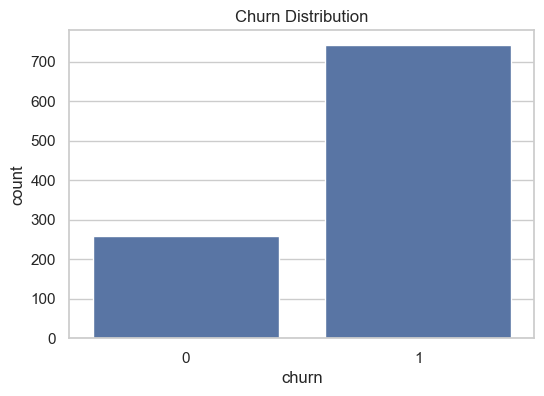

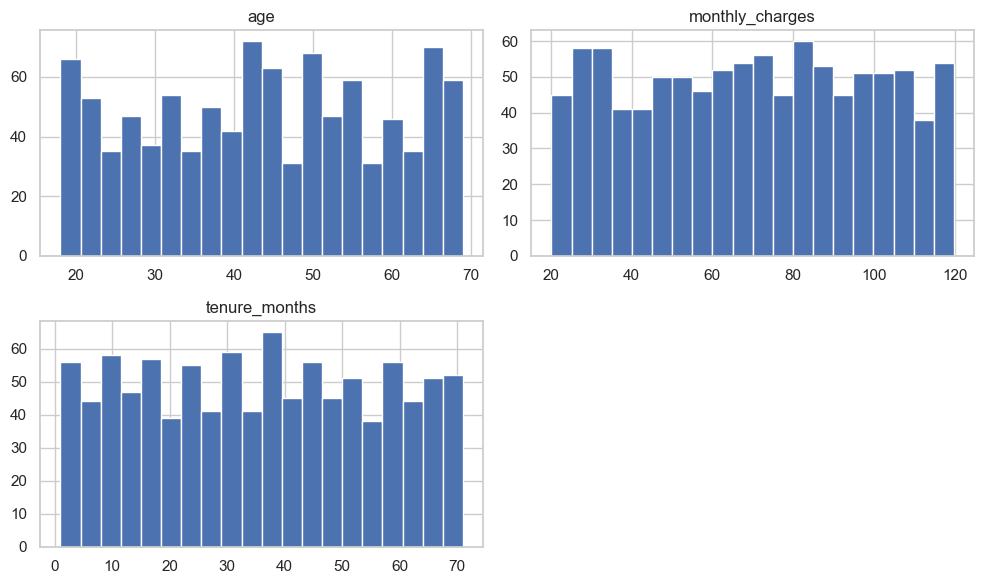

In [3]:
# Missing Values
print("Missing Values:")
print(df.isnull().sum()[df.isnull().sum() > 0])

# Target Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='churn', data=df)
plt.title('Churn Distribution')
plt.show()

# Numerical Distributions
df[['age', 'monthly_charges', 'tenure_months']].hist(bins=20, figsize=(10, 6))
plt.tight_layout()
plt.show()

## 3. Data Preprocessing

In [4]:
# Handling Missing Values
df['internet_service'].fillna('No', inplace=True)
df['tech_support'].fillna('No', inplace=True)
df['monthly_data_gb'].fillna(0, inplace=True)

# Feature Engineering / Selection
X = df.drop(['customer_id', 'churn'], axis=1)
y = df['churn']

categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

C:\Users\Omar\AppData\Local\Temp\ipykernel_11712\2953091489.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['internet_service'].fillna('No', inplace=True)
C:\Users\Omar\AppData\Local\Temp\ipykernel_11712\2953091489.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

## 4. Model Development & Hyperparameter Tuning
We will use `RandomizedSearchCV` to find optimal hyperparameters for Random Forest and XGBoost.

In [5]:
# Define Models and Parameter Grids
models_params = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, class_weight='balanced'),
        "params": {}
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42, class_weight='balanced'),
        "params": {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__max_depth': [None, 10, 20, 30],
            'classifier__min_samples_split': [2, 5, 10]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=sum(y==0)/sum(y==1)),
        "params": {
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__max_depth': [3, 5, 7],
            'classifier__n_estimators': [50, 100, 200]
        }
    }
}

results = {}

for name, mp in models_params.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', mp['model'])])
    
    if mp['params']:
        print(f"Tuning {name}...")
        clf = RandomizedSearchCV(pipeline, mp['params'], n_iter=10, cv=3, scoring='f1', random_state=42, n_jobs=-1)
    else:
        clf = pipeline
    
    clf.fit(X_train, y_train)
    
    # Best estimator if tuned
    if hasattr(clf, 'best_estimator_'):
        best_model = clf.best_estimator_
        print(f"Best params for {name}: {clf.best_params_}")
    else:
        best_model = clf

    # Predict
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]
    
    # Metrics
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    
    results[name] = {
        "F1-Score": f1, "ROC-AUC": roc_auc, "Accuracy": acc, 
        "Precision": prec, "Recall": rec, "Model": best_model
    }
    
    print(f"\n{name} Performance:")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC: {roc_auc:.4f}")


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.53      0.81      0.64        52
           1       0.92      0.74      0.82       148

    accuracy                           0.76       200
   macro avg       0.72      0.78      0.73       200
weighted avg       0.81      0.76      0.77       200

ROC-AUC: 0.8465
Tuning Random Forest...
Best params for Random Forest: {'classifier__n_estimators': 100, 'classifier__min_samples_split': 10, 'classifier__max_depth': 10}

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.61      0.88      0.72        52
           1       0.95      0.80      0.87       148

    accuracy                           0.82       200
   macro avg       0.78      0.84      0.80       200
weighted avg       0.86      0.82      0.83       200

ROC-AUC: 0.8859
Tuning XGBoost...


d:\Model\Customer_Churn_Model\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [20:08:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params for XGBoost: {'classifier__n_estimators': 50, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.1}

XGBoost Performance:
              precision    recall  f1-score   support

           0       0.58      1.00      0.74        52
           1       1.00      0.75      0.86       148

    accuracy                           0.81       200
   macro avg       0.79      0.88      0.80       200
weighted avg       0.89      0.81      0.83       200

ROC-AUC: 0.8819


## 5. Model Comparison & Visualization
We compare the models using F1-Score (harmonic mean of precision and recall) and ROC-AUC (ability to distinguish between classes).

                     F1-Score   ROC-AUC Accuracy Precision    Recall
Logistic Regression  0.820896  0.846544     0.76  0.916667  0.743243
Random Forest        0.871795  0.885915    0.825     0.952  0.804054
XGBoost              0.857143  0.881887    0.815       1.0      0.75


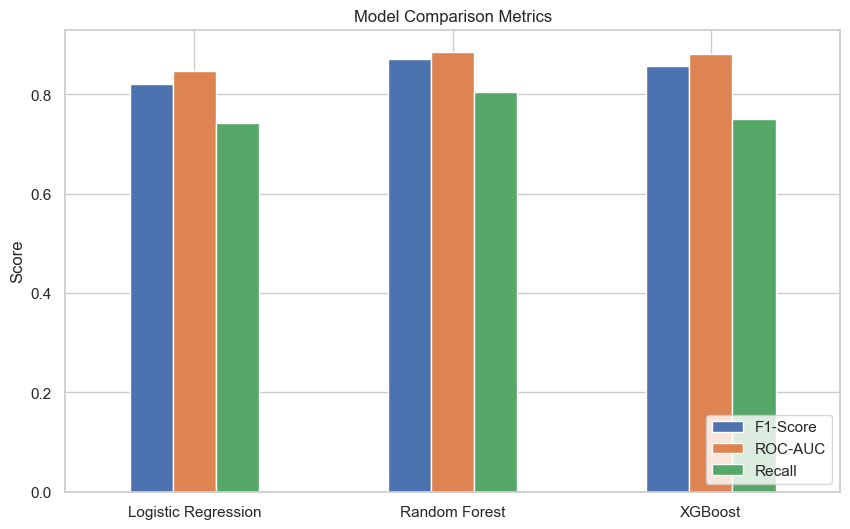


Best Model based on F1-Score: Random Forest


In [6]:
results_df = pd.DataFrame(results).T.drop('Model', axis=1)
print(results_df)

# Visualization
metrics_to_plot = ['F1-Score', 'ROC-AUC', 'Recall']
results_df[metrics_to_plot].plot(kind='bar', figsize=(10, 6))
plt.title('Model Comparison Metrics')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()

best_model_name = results_df['F1-Score'].idxmax()
print(f"\nBest Model based on F1-Score: {best_model_name}")

## 6. Feature Importance (Best Model)

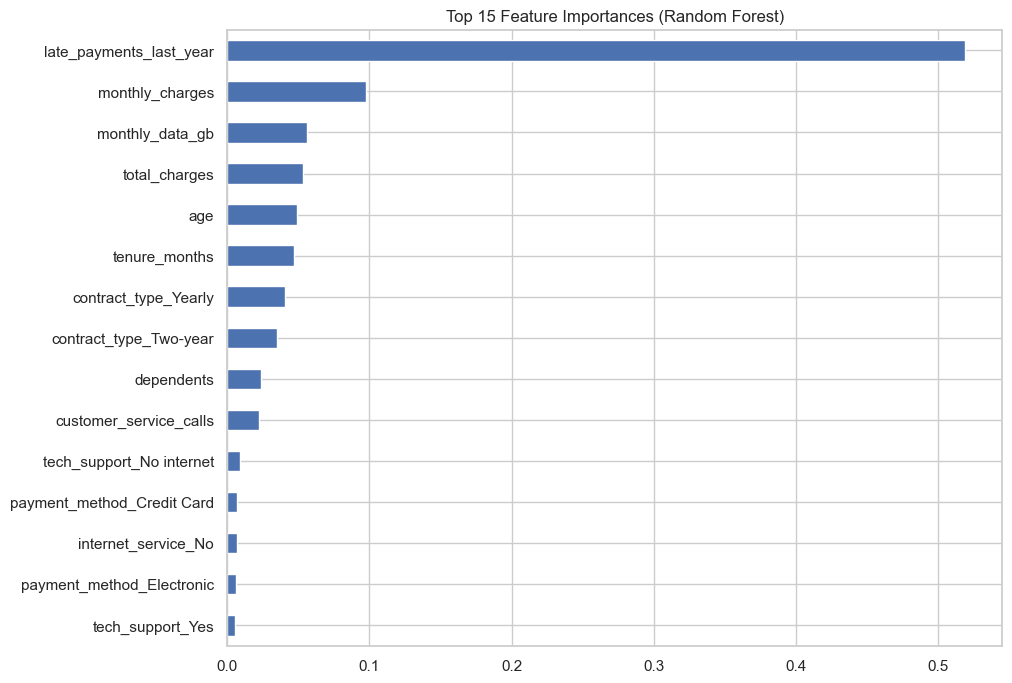

In [7]:
best_model_pipeline = results[best_model_name]['Model']

if best_model_name == "Logistic Regression":
    importances = best_model_pipeline.named_steps['classifier'].coef_[0]
    feature_names = (numerical_cols.tolist() + 
                     best_model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols).tolist())
else:
    importances = best_model_pipeline.named_steps['classifier'].feature_importances_
    feature_names = (numerical_cols.tolist() + 
                     best_model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols).tolist())

feat_imp = pd.Series(importances, index=feature_names).sort_values(key=abs, ascending=False)

plt.figure(figsize=(10, 8))
feat_imp.head(15).plot(kind='barh')
plt.title(f'Top 15 Feature Importances ({best_model_name})')
plt.gca().invert_yaxis()
plt.show()